# Calculate distances and find neighbors

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import poligrain as plg

## Point-to-point distances

### Get PWS dataset

In [3]:
!curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/pws/data_PWS_netCDF_AMS_float.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

  0 10.7M    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 90 10.7M   90 9981k    0     0  5445k      0  0:00:02  0:00:01  0:00:01 16.4M
100 10.7M  100 10.7M    0     0  5716k      0  0:00:01  0:00:01 --:--:-- 15.6M


In [4]:
ds_pws = xr.open_dataset("data_PWS_netCDF_AMS_float.nc")

# fix some issues with this dataset
ds_pws["time"] = pd.to_datetime(ds_pws.time.data, unit="s")
ds_pws["lon"] = ("id", ds_pws.lon.data)
ds_pws["lat"] = ("id", ds_pws.lat.data)

### Project cooridnates from lon-lat to UTM zone for Europe

To do meaningful distance calculations we have to project the lon-lat coordinates first.

Info on the UTM zone 32N projection `'EPSG:25832'` that is used can be found [here](https://epsg.io/25832#google_vignette)

Note that `plg.spatial.project_coordinates` can also use a different source coordinate system, but its default is WGS 84 (lon and lat in degrees), which is `'EPSG:4326'` 

In [5]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    ds_pws.lon, ds_pws.lat, "EPSG:25832"
)

In [5]:
ds_pws

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB ...
    lat        (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon        (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x          (id) float64 1kB 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 1kB 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 235MB ...
Attributes:
    title:         PWS data from Amsterdam
    institution:   Wageningen University and Research, Department of Environm...
    history:       Test Version 0.1
    references:    https://doi.org/10.1029/2019GL083731
    date_created:  2022-10-18 10:32:00
    Conventions:   OPENSENSE V0
    location:      Amsterdam Metropolitan Area
    source:        Netamo
    comment:

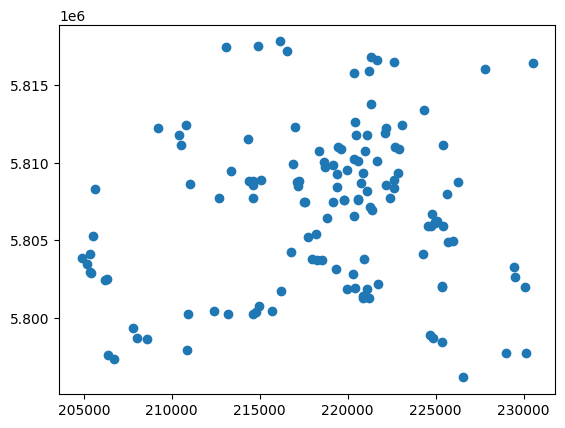

In [6]:
plt.scatter(ds_pws.x, ds_pws.y);

### Distance matrix

#### Calculate distance matrix

Beware that the distance matrix can become quite large when using large datasets, e.g. 800 MB if you use 10,000 stations against 10,000 stations from a country-wide PWS dataset, and calculation can take tens of seconds. We might add the option to calculate a sparse distance matrix only up the certain distances later, which reduced size and computation time signficantly.

For the typicall use case to find nearby stations, you can just use the nearest neighbor lookup described below for large datasets. The distance matrix can still be quite nice and handy for small regional datasets.

In [6]:
distance_matrix = plg.spatial.calc_point_to_point_distances(
    ds_pws,
    ds_pws,
)

distance_matrix

<xarray.DataArray (id: 134, id_neighbor: 134)> Size: 144kB
array([[    0.        ,   518.79828487,   531.99603941, ...,
        28532.23134009, 25291.03668667, 25994.5064412 ],
       [  518.79828487,     0.        ,   728.38027968, ...,
        28493.8273213 , 24995.94592241, 25633.14869253],
       [  531.99603941,   728.38027968,     0.        , ...,
        28000.75903421, 24846.06853717, 25603.62271956],
       ...,
       [28532.23134009, 28493.8273213 , 28000.75903421, ...,
            0.        , 14448.29575676, 18710.76846276],
       [25291.03668667, 24995.94592241, 24846.06853717, ...,
        14448.29575676,     0.        ,  4264.61589559],
       [25994.5064412 , 25633.14869253, 25603.62271956, ...,
        18710.76846276,  4264.61589559,     0.        ]])
Coordinates:
  * id           (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 3kB 'ams1' 'ams2' ... 'ams133' 'ams134'

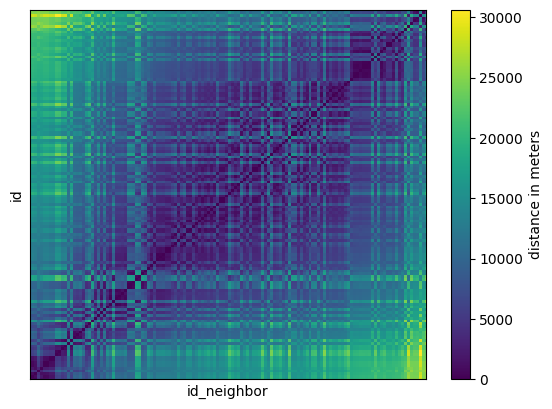

In [7]:
distance_matrix.plot(cbar_kwargs={"label": "distance in meters"})
plt.xticks([])
plt.yticks([]);

#### Plot locations with distance to selected station

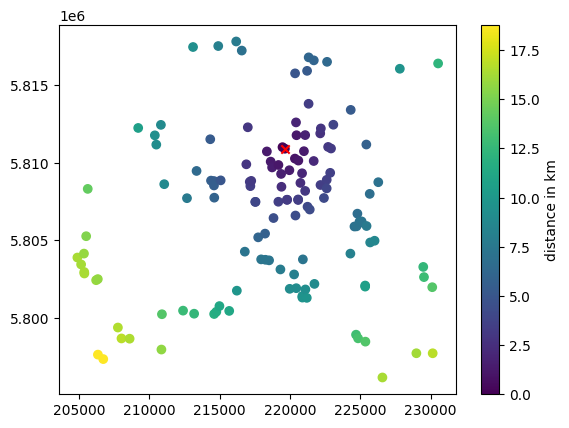

In [8]:
pws_id = "ams63"

sc = plt.scatter(ds_pws.x, ds_pws.y, c=distance_matrix.sel(id=pws_id) / 1e3)
plt.scatter(ds_pws.sel(id=pws_id).x, ds_pws.sel(id=pws_id).y, c="r", marker="x")
plt.colorbar(sc, label="distance in km");

#### Select neighbors within certain range from distance matrix

Note that this can be done more easily with the nearest neighbor lookup shown below. But you might findet having the distance matrix and getting the neigbors from there a nicer solution.

In [9]:
pws_id = "ams63"

max_distance = 3e3  # this is in meteres

distances = distance_matrix.sel(id=pws_id)
selected_neighbor_ids = ds_pws.id.data[distances < max_distance]
selected_neighbor_ids

array(['ams41', 'ams42', 'ams51', 'ams54', 'ams55', 'ams58', 'ams60',
       'ams61', 'ams62', 'ams63', 'ams67', 'ams69', 'ams70', 'ams71',
       'ams74', 'ams78', 'ams80', 'ams83', 'ams84', 'ams94', 'ams96',
       'ams97'], dtype='<U6')

### Nearest neighbor lookup

This uses `scipy.spatial.KDTree` for fast lookup of nearest neighbors and distance calculation. In the resulting `xarray.Dataset` the IDs of the neighboring stations are `None` for the cases where their distance is larger than `max_distance`.

#### Get N closest points for two point datasets

In [13]:
ds_pws

<xarray.Dataset> Size: 237MB
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 2kB 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    lat        (id) float64 1kB 52.31 52.3 52.31 52.35 ... 52.43 52.3 52.26
    lon        (id) float64 1kB 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x          (id) float64 1kB 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 1kB 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 235MB ...
Attributes:
    title:         PWS data from Amsterdam
    institution:   Wageningen University and Research, Department of Environm...
    history:       Test Version 0.1
    references:    https://doi.org/10.1029/2019GL083731
    date_created:  2022-10-18 10:32:00
    Conventions:   OPENSENSE V0
    location:      Amsterdam Metropolitan Area
    source:        Netamo
    comment:

In [ ]:
closest_neigbors = plg.spatial.get_closest_points_to_point(
    ds_points=ds_pws,
    ds_points_neighbors=ds_pws,
    max_distance=max_distance,
    n_closest=25,
    id_var_points="id",
    id_var_neighbors="id",
)

In [21]:
closest_neigbors

<xarray.Dataset> Size: 57kB
Dimensions:      (n_id: 134, n_closest: 25)
Coordinates:
  * n_id         (n_id) <U6 3kB 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
Dimensions without coordinates: n_closest
Data variables:
    distance     (n_id, n_closest) float64 27kB 0.0 518.8 532.0 ... inf inf inf
    neighbor_id  (n_id, n_closest) object 27kB 'ams1' 'ams2' ... None None

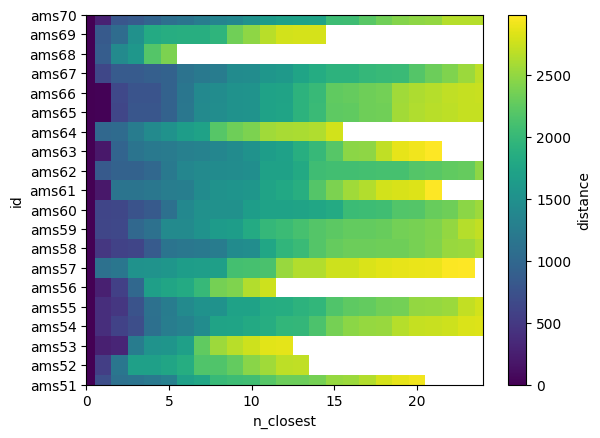

In [13]:
closest_neigbors.isel(id=slice(50, 70)).distance.plot();

One interesting thing might be the distance of the closest station, which is at index 1 of `n_closest` in our case because at index 0 is each station itself.

Note that there is no data point if there is not neigbor within `max_distance`.

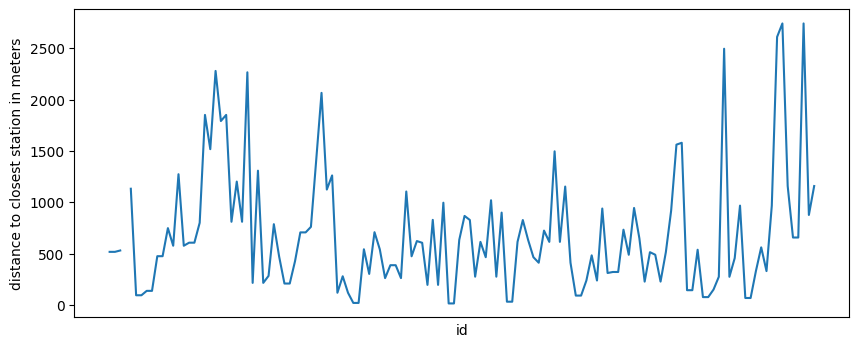

In [14]:
closest_neigbors.isel(n_closest=1).distance.plot(figsize=(10, 4))
plt.xticks([])
plt.ylabel("distance to closest station in meters");

#### Get IDs of closest points

We can also get the station IDs of the closest neighbors. Note that they are different for each target station ID and they are sorted by ascending distance.

In [15]:
pws_id = "ams63"

neighbor_ids = closest_neigbors.sel(id=pws_id).neighbor_id.dropna(dim="n_closest")
neighbor_ids

<xarray.DataArray 'neighbor_id' (n_closest: 22)> Size: 176B
array(['ams63', 'ams61', 'ams70', 'ams58', 'ams71', 'ams74', 'ams51',
       'ams54', 'ams83', 'ams67', 'ams55', 'ams60', 'ams84', 'ams69',
       'ams80', 'ams94', 'ams78', 'ams62', 'ams96', 'ams97', 'ams42',
       'ams41'], dtype=object)
Coordinates:
    id       <U6 24B 'ams63'
Dimensions without coordinates: n_closest

These should be the same neighboring station IDs as derive from the distance matrix above, since we have chosen the same ID as target station. This is, however, only true if `n_closets` does not cut off the list for `get_closest_points_to_point()`. For the chosen values in this example the two sets of neighboring IDs should be the same. Let's check that.

In [16]:
set(selected_neighbor_ids) == set(neighbor_ids.data)

True

#### Plot stations and mark closest neighbors

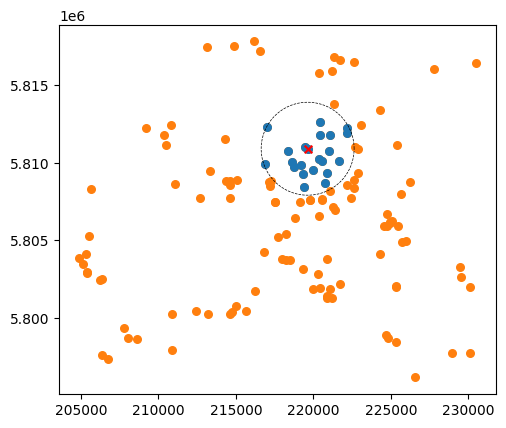

In [17]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

ax.scatter(ds_pws.x, ds_pws.y, c="C1", s=30)

neighbor_ids = closest_neigbors.sel(id=pws_id).neighbor_id.dropna(dim="n_closest")
ds_pws_neighbors = ds_pws.sel(id=neighbor_ids)
ax.scatter(ds_pws_neighbors.x, ds_pws_neighbors.y, c="C0", s=30)

ax.scatter(
    ds_pws.sel(id=pws_id).x, ds_pws.sel(id=pws_id).y, color="r", s=30, marker="x"
)

# Plot a circel with max_distance to see if the selections fits
an = np.linspace(0, 2 * np.pi, 100)
ax.plot(
    ds_pws.x.sel(id=pws_id).data + max_distance * np.cos(an),
    ds_pws.y.sel(id=pws_id).data + max_distance * np.sin(an),
    color="k",
    linestyle="--",
    linewidth=0.5,
)
plt.title("");

Note that not all stations within the circle will be marked in case that `n_closest` cuts off the list of nearby stations.

## Line-to-points distances
This example shows how to use plg.spatial.get_closest_points_to_line to find points close to CMLs. We use CMLs from the OpenMerge dataset. The full dataset contains raingauges, but they where not unzippet and thus not readily available. We instead modify some of the CMLs so they look like raingauges by using the CML midpoints.

### Download CML data from training school example

In [18]:
!curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/cml/openMRG_example.nc

### Remove unnecessary data and turn some CMLs into points

In [19]:
# Load downloaded CML data
ds_cmls = xr.open_dataset("./openMRG_example.nc")

# We only need metadata, so we drop tsl and rsl here
ds_cmls = ds_cmls.drop_vars(["tsl", "rsl"]).drop_dims("time")

# Select some cmls, these are used as rain gauges
gauges_ind = np.arange(0, ds_cmls.cml_id.size, 20)


# Get cml indices that is not rain gauges
cml_ind = np.arange(0, ds_cmls.cml_id.size)
cml_ind = cml_ind[~np.isin(cml_ind, gauges_ind)]

# Update both datasets with new non-overlapping indices
ds_gauges = ds_cmls.isel(cml_id=gauges_ind)
ds_cmls = ds_cmls.isel(cml_id=cml_ind)

# Restructure ds_gauges so it has PWS standard names:
ds_gauges = ds_gauges.drop_dims("sublink_id").rename({"cml_id": "id"})

# Use midpoint as gauge point
ds_gauges.coords["lat"] = (ds_gauges.site_0_lat + ds_gauges.site_1_lat) / 2
ds_gauges.coords["lon"] = (ds_gauges.site_0_lon + ds_gauges.site_1_lon) / 2
ds_gauges = ds_gauges.drop_vars(
    [
        "site_0_lat",
        "site_1_lat",
        "site_0_lon",
        "site_1_lon",
    ]
)

# Reformat ids to str, a more common format
ds_gauges.coords["id"] = ds_gauges.id.astype(str)
ds_cmls.coords["cml_id"] = ds_cmls.cml_id.astype(str)

### Project cooridnates from lon-lat to UTM zone for Europe

In [20]:
# Project coordinates for rain gauges
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, "EPSG:25832"
)

# Project coordinates for CMLs
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, "EPSG:25832"
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, "EPSG:25832"
)

### Nearest neighbor lookup
Uses KDTree for fast neighbour lookup

In [21]:
max_distance = 20000  # in meters due to the projection EPSG:25832
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cmls, ds_gauges, max_distance=max_distance, n_closest=25
)

In [22]:
closest_neigbors

<xarray.Dataset> Size: 167kB
Dimensions:      (cml_id: 345, n_closest: 25)
Coordinates:
  * cml_id       (cml_id) <U21 29kB '10002' '10003' '10004' ... '10363' '10364'
Dimensions without coordinates: n_closest
Data variables:
    distance     (cml_id, n_closest) float64 69kB 2.745e+03 3.167e+03 ... inf
    neighbor_id  (cml_id, n_closest) object 69kB '10001' '10041' ... None None

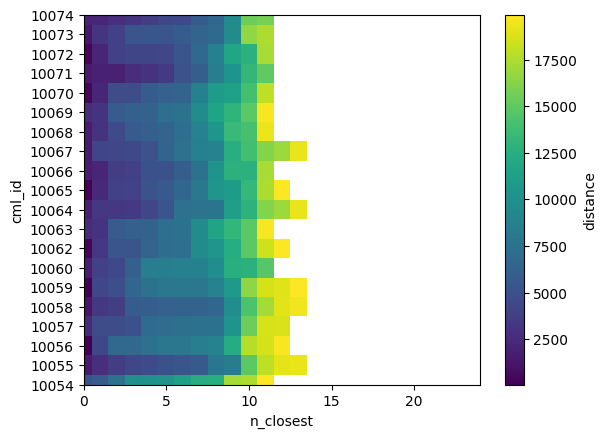

In [23]:
closest_neigbors.isel(cml_id=slice(50, 70)).distance.plot()

We can get the nearest neighbour by selecting the first element in n_closest. 

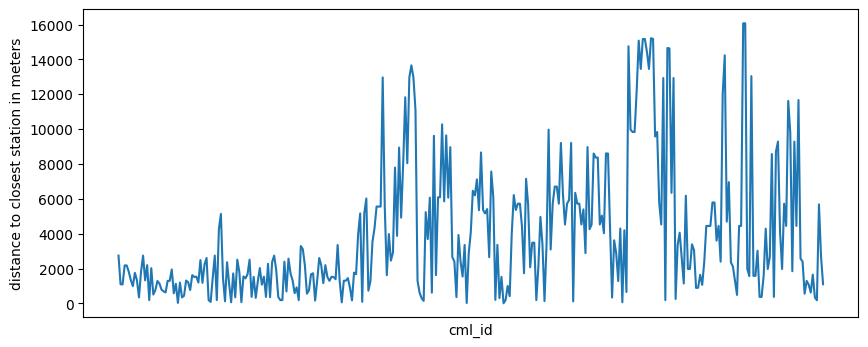

In [24]:
closest_neigbors.isel(n_closest=0).distance.plot(figsize=(10, 4))
plt.xticks([])
plt.ylabel("distance to closest station in meters");

We can also get the IDs of the closest gauges of a CML

In [25]:
gauge_id = "10002"
neighbor_ids = closest_neigbors.sel(cml_id=gauge_id).neighbor_id.dropna(dim="n_closest")
neighbor_ids

<xarray.DataArray 'neighbor_id' (n_closest: 13)> Size: 104B
array(['10001', '10041', '10221', '10081', '10101', '10021', '10181',
       '10361', '10121', '10061', '10141', '10341', '10161'], dtype=object)
Coordinates:
    cml_id   <U21 84B '10002'
Dimensions without coordinates: n_closest

#### Plot CMLs that are close to rain gauges

In [26]:
gauge_ids = [13, 16]  # [13, 16] # Select only 2 rain gauges
max_distance = 5500  # Distance in meters
closest_neigbors = plg.spatial.get_closest_points_to_line(
    ds_cmls, ds_gauges.isel(id=gauge_ids), max_distance=max_distance, n_closest=1
).isel(n_closest=0)

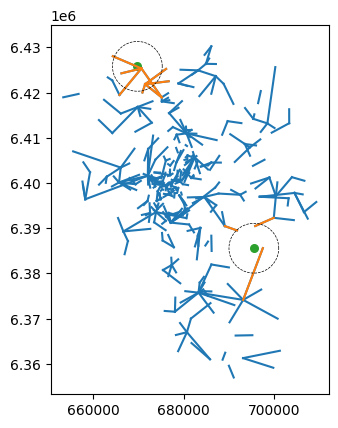

In [27]:
fig, ax = plt.subplots()
ax.set_aspect("equal")

# Plot all CMLs
for cml_id in ds_cmls.cml_id:
    plt.plot(
        [ds_cmls.sel(cml_id=cml_id).site_0_x, ds_cmls.sel(cml_id=cml_id).site_1_x],
        [ds_cmls.sel(cml_id=cml_id).site_0_y, ds_cmls.sel(cml_id=cml_id).site_1_y],
        "C0",
    )

# Plot CMLs close to selected gauges
nearby_cml_id = closest_neigbors.neighbor_id.dropna(dim="cml_id").cml_id
for cml_id in nearby_cml_id:
    plt.plot(
        [ds_cmls.sel(cml_id=cml_id).site_0_x, ds_cmls.sel(cml_id=cml_id).site_1_x],
        [ds_cmls.sel(cml_id=cml_id).site_0_y, ds_cmls.sel(cml_id=cml_id).site_1_y],
        "C1",
    )

# Plot selected rain gauges
ax.scatter(ds_gauges.isel(id=gauge_ids).x, ds_gauges.isel(id=gauge_ids).y, c="C2", s=30)

# Plot a circel with max_distance to see if the selections fits
an = np.linspace(0, 2 * np.pi, 100)
for gauge_id in gauge_ids:
    ax.plot(
        ds_gauges.x.isel(id=gauge_id).data + max_distance * np.cos(an),
        ds_gauges.y.isel(id=gauge_id).data + max_distance * np.sin(an),
        color="k",
        linestyle="--",
        linewidth=0.5,
    )
    plt.title("")